# **Data Visualisation**

## Objectives

* Fulfil Business Requirement 1: 
Visually differentiate a healthy cherry leaf from one with powdery mildew.

* Answer hypothesis #2:
Average, variability and contrast plots can be improved by rotating and aligning leaves to same orientation before analysis

## Inputs

* inputs/datasets/raw/cherry-leaves/test 

## Outputs

For raw and rotated images each:
* Thumbnail montage to display random selection of images from each label
* Average and Variability image plots for each label - healthy and mildew-infected
* Difference/contrast between labels image plot

Rotated image dataset:
* inputs/datasets/rotated

## Additional Comments | Insights | Conclusions

* 



---

# Setup

## Library Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shutil
import random
import cv2
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## Set working directory

Change the working directory from its current folder to its parent folder

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector/jupyter_notebooks'

Make the parent of the current directory the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector'

## Set input directories

set paths to specific data folders required in notebook

In [5]:
raw_data_dir = 'inputs/datasets/raw/cherry-leaves'
test_data_dir = 'inputs/datasets/raw/cherry-leaves/test'
rotated_data_dir = 'inputs/datasets/rotated'

print('the raw data directory is', raw_data_dir)
print('the test data directory is', test_data_dir)
print('the rotated data directory is', rotated_data_dir)

the raw data directory is inputs/datasets/raw/cherry-leaves
the test data directory is inputs/datasets/raw/cherry-leaves/test
the rotated data directory is inputs/datasets/rotated


## Set output directory

In [6]:
version = 'v1' # change version number for each iteration
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('This version is already available - create a new version if required.')
    pass
else:
    os.makedirs(name=file_path)

This version is already available - create a new version if required.


## Set labels

In [7]:
labels = os.listdir(test_data_dir)
print('Labels for images are', labels)

Labels for images are ['healthy', 'powdery_mildew']


---

# Initial visual inspection

### Create a montage from a small selection of images for each label
* This provides an initial overview of image quality and content

Define function for generating montage

In [47]:
def generate_thumbnail_montage(data_dir, labels, new_size=(150, 150)):
    """
    Generates a single thumbnail montage with 2x2 grids for each label side-by-side.
    Args:
        data_dir (str): Path to the dataset directory.
        labels (list): List of labels (subfolders) to sample from.
        new_size (tuple): Desired size of each thumbnail image.

    Returns:
        None. Displays the montage in a Matplotlib plot.
    """
    if len(labels) != 2:
        raise ValueError("This function assumes exactly 2 labels for side-by-side layout.")

    # Create a figure for the montage
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows (for 2x2 grids), 4 columns (2x2 per label)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing between subplots

    for i, label in enumerate(labels):
        label_dir = os.path.join(data_dir, label)
        image_filenames = random.sample(os.listdir(label_dir), 4)  # Select 4 random images per label

        # Plot the 2x2 grid for the current label
        for j, img_file in enumerate(image_filenames):
            row = j // 2  # Determine row index (0 or 1)
            col = j % 2 + (i * 2)  # Determine column index; offset by 2 for the second label
            img_path = os.path.join(label_dir, img_file)
            img = image.load_img(img_path, target_size=new_size)
            img_array = image.img_to_array(img) / 255.0  # Normalize image

            # Display the image in the correct subplot
            axes[row, col].imshow(img_array)
            axes[row, col].axis('off')

        # Add a title spanning the 2x2 grid for the current label
        axes[0, i * 2].set_title(f"{label.capitalize()}", fontsize=16, loc='center')
        axes[0, i * 2 + 1].set_title("")  # Clear title for adjacent subplot

    plt.tight_layout()

    # Option to save the plot as a PNG file if required
    save_plot = input("Do you want to save this plot? (yes/no): ").strip().lower()

    if save_plot == "yes":
        output_path = os.path.join(file_path, "thumbnail_montage.png")
        plt.savefig(output_path, bbox_inches="tight", dpi=150)
        print(f"Montage saved to {output_path}")
    else:
        print("Montage not saved.")


    # Show the montage
    plt.show()



Call function to generate montage

Montage saved to outputs/v1/thumbnail_montage.png


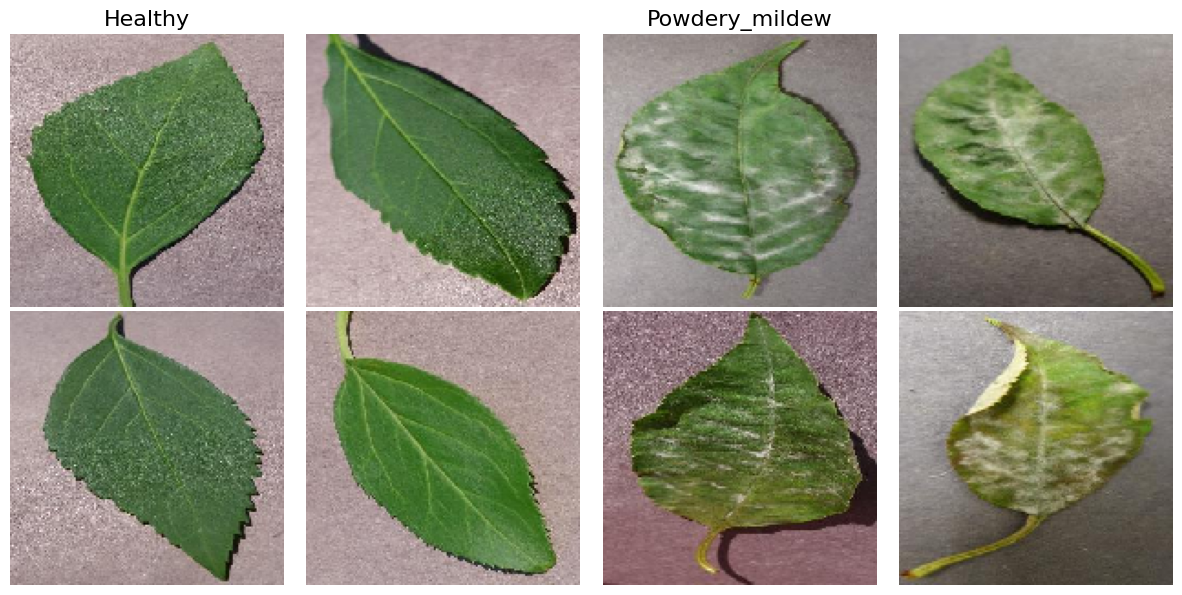

In [48]:

generate_thumbnail_montage(data_dir=test_data_dir, labels=labels, new_size=(150, 150))

---

# Image Average, Variability and Difference

## Average and variabilty of images per label

Define function to load images in array

In [9]:

def load_images(my_data_dir, new_size=(50, 50), n_images_per_label=None):
    """
    Loads and preprocesses images from a directory into arrays.
    Parameters:
        my_data_dir (str): Path to the directory containing label subfolders.
        new_size (tuple): Tuple of (height, width) to resize images.
        n_images_per_label (int): Limit the number of images per label.
    Returns:
        X (numpy array): Array of image data with shape (n_samples, height, width, channels).
        y (numpy array): Array of corresponding labels.
    """
    X, y = [], []

    for label in labels:
        counter = 0
        for image_filename in os.listdir(f"{my_data_dir}/{label}"):
            if n_images_per_label is None or counter < n_images_per_label:
                # Load and resize the image
                img = image.load_img(f"{my_data_dir}/{label}/{image_filename}", target_size=new_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
                
                # Append image data and label
                X.append(img_array)
                y.append(label)
                counter += 1

    return np.array(X), np.array(y)

Define function to calculate average and vairability of image per label

In [27]:
def calculate_mean_and_variability(X, y, file_path=file_path, figsize=(12, 5)):
    """
    Calculates and plots the average and variability for each label.
    Parameters:
        X (numpy array): Image data array of shape (n_samples, height, width, channels).
        y (numpy array): Array of corresponding labels.
        file_path : Path to save the output plots to correct version folder.
        figsize (tuple): Size of the plots.
    """
    unique_labels = np.unique(y)
    for label in unique_labels:
        # Filter images for the current label
        label_mask = y == label
        label_images = X[label_mask]

        # Calculate mean and variability
        avg_img = np.mean(label_images, axis=0)
        std_img = np.std(label_images, axis=0)

        print(f"==== Label {label} ====")
        print(f"Image Shape: {avg_img.shape}")
        
        # Plotting
        sns.set_style("white")
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].set_title(f"Average Image: {label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability Image: {label}")
        axes[1].imshow(std_img, cmap='gray')

        plt.tight_layout()

        # Option to save the plot as a PNG file if required
        save_plot = input("Do you want to save this plot? (yes/no): ").strip().lower()

        if save_plot == "yes":
            output_path = os.path.join(file_path, f"mean_var_montage_{label}_{version}.png")
            plt.savefig(output_path, bbox_inches="tight", dpi=150)
            print(f"Montage saved to {output_path}")
        else:
            print("Montage not saved.")

        plt.show()


Defiine path to dataset and image size

In [31]:
mean_var_path = test_data_dir
# Target image dimensions - could also use image size .pkl file
image_shape = (258, 258, 3)  

Load sample of images - vary sample size to adapt to accuracy requirements
* 50: not very accurate but fast computation speed
* 100-200: resonable accuracy but slower computation
* 500+: high accuracy but very slow computation

**NB:** image size will also impact accuracy and computation speeds

In [34]:
X, y = load_images(my_data_dir=mean_var_path, new_size=image_shape[:2], n_images_per_label=500)

Calculate and plot average and variability

==== Label healthy ====
Image Shape: (258, 258, 3)
Montage saved to outputs/v1/mean_var_montage_healthy_v1.png


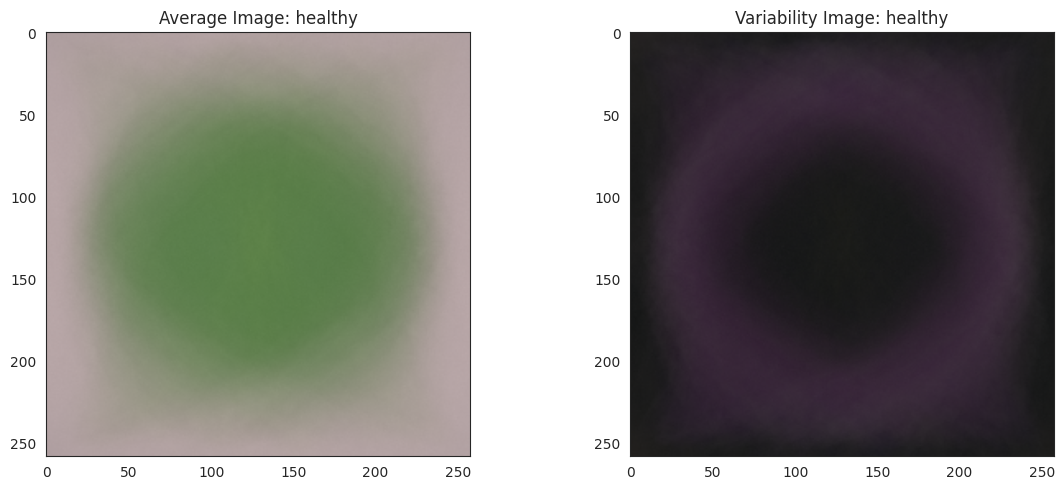

==== Label powdery_mildew ====
Image Shape: (258, 258, 3)
Montage saved to outputs/v1/mean_var_montage_powdery_mildew_v1.png


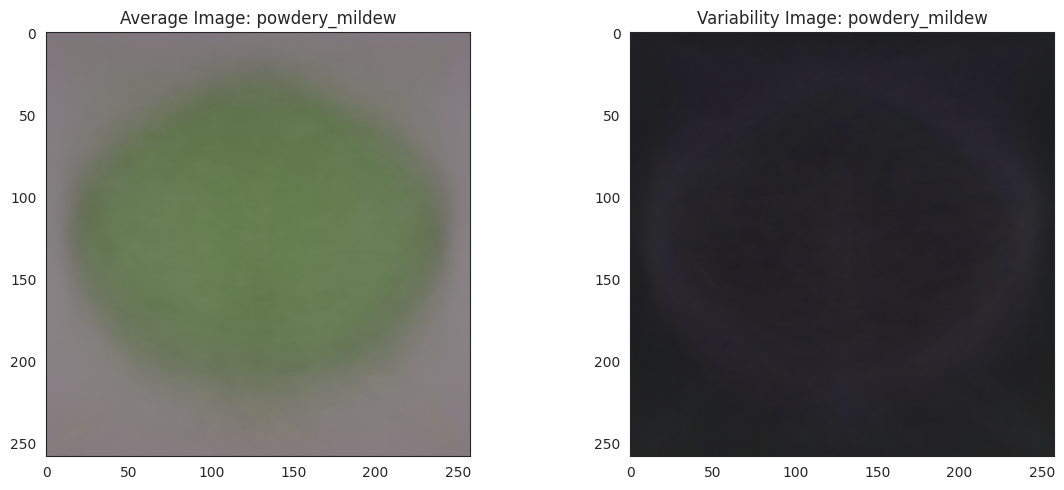

In [36]:
calculate_mean_and_variability(X, y, file_path=file_path)

### Conclusion | Initial Assessment
* Average and variability plots are not very informative, even when image size is full resolution and 500 images used per label.
* Accuracy is impacted because leaves have very defined shape and are not in same orientation in every image

### Next steps
* find a way to rotate images so leaves in same orientation before carrying out average and variability analysis

## Image Rotation

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
